##  Age-structured SIR model for India

Assume that the population has been partitioned into  $i=1,\ldots, M$ age groups and that we have available the $M\times M$ contact matrix $C_{ij}$. These are a sum of contributions from contacts at home, workplace, schools and all other public spheres. Using superscripts $H$, $W$, $S$ and $O$ for each of these, we write the contact matrix as
$$
C_{ij} = C^H_{ij} + C^W_{ij} + C^S_{ij} + C^O_{ij}
$$
We read in these contact matrices from the data sets provided in the paper *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al, sum them to obtain the total contact matrix. We also read in the age distribution of India obtained from the *Population pyramid* website. The infection parameter $\beta$ is unknown, so we fit it to the case data till 25th March. The hope is that this will take into account the fact that there are, in reality, asymptomatic infectives, and that the symptomatic cases are an understimate. Also, the model is being applied to the whole of India, where the well-mixedness of the population, implicit in a non-spatial model, breaks down. This type of fitting gets more accurate, though, when it is applied to more local regions, where the well-mixedness is a better assumption. We then run the simulation, assuming all initial cases are symptomatic, and remain so. This will be an underestimate in the initial stages but once the epidemic enters the non-linear phase, there will be must less sensitivity to the initial condition. At the end of the simulation, we extract the number of susceptibles remaining in each age group, and the difference with the initial number of susceptibles is the total number that are infected. We multiply this with mortality data from China to obtain mortality estimates. 

------------------------------------------------------------------------------------------------------------------------------

#### After creating/cloning a new environment, with all the dependencies, either using conda or from ArcGIS Pro. 
#### (As per the instructions in the Readme.md)
#### Proceed with this notebook.

------------------------------------------------------------------------------------------------------------------------------

**Model A: no lockdown**

---

* Checking Env.

In [ ]:
#forked from Rajesh Singh's work, related to Pyross Lib.
import sys
sys.executable

---

* Importing all req. libraries.

In [1]:
%matplotlib inline                  
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt     # optional for notebook visualization.

# imports for AGOL publishing
from arcgis.gis import GIS

---

* Loading & defining model parameters:

In [2]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [3]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO

In [4]:
beta  = 0.01646692       # infection rate 
gIa   = 1./7             # recovery rate of asymptomatic infectives 
gIs   = 1./7             # recovery rate of symptomatic infectives 
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1

Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

---

* Running the Model & Creating Model file

In [5]:
# duration of simulation and data file
# tf - no of days starting from 23 feb 2020 for india, Nf - no of prediction data points. 

Tf=200;  Nf=200;

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# input data, inside model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.models.SIR(parameters, M, Ni)


# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

---

* Getting the Results ready for ArcGIS online ___>>>___ Then to Dashboard.

In [ ]:
# Loading predictions

IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
        
# Loading actual data, kindly update the data by subtracting recovered & no of deaths, so far.

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]

In [ ]:
# Making the results, ArcGIS Online compatible

main_table = pd.DataFrame(data=IC, columns=["no of predicted cases"])
main_table['date'] = pd.date_range(start='2/23/2020', periods=len(main_table), freq='D')
main_table['no of predicted cases'] = main_table['no of predicted cases'].apply(np.int64)


true_no_of_cases= pd.DataFrame(data=cases, columns=["no of actual cases"])

final_table = pd.concat([main_table, true_no_of_cases], axis=1, sort=False)
col = final_table.columns.tolist()
col = col[-1:] + col[:-1]; col = col[-1:] + col[:-1]
final_table = final_table[col]  

final_table.to_excel (r'_Model_A_.xlsx', index = False, header=True)

final_table.head()

---

* Publish the results on AGOL

In [ ]:
# provide your AGOL account details below:
# for more help go to https://developers.arcgis.com/python/sample-notebooks/publishing-sd-shapefiles-and-csv/

username = "username"
password = "password"
gis = GIS("link", username, password)


table_file = '_Model_A_.xlsx'


online_table= gis.content.add({'type': 'Microsoft Excel'}, table_file)

#provide the folder name
folder='covid_dsb_test'


# Move the table
online_table.move(folder)

#publishing the table
model_initial = online_table.publish(overwrite=True)
model_initial.move(folder)

#add the layer to your Dashboard.

---

* Optional Notebook visualization 

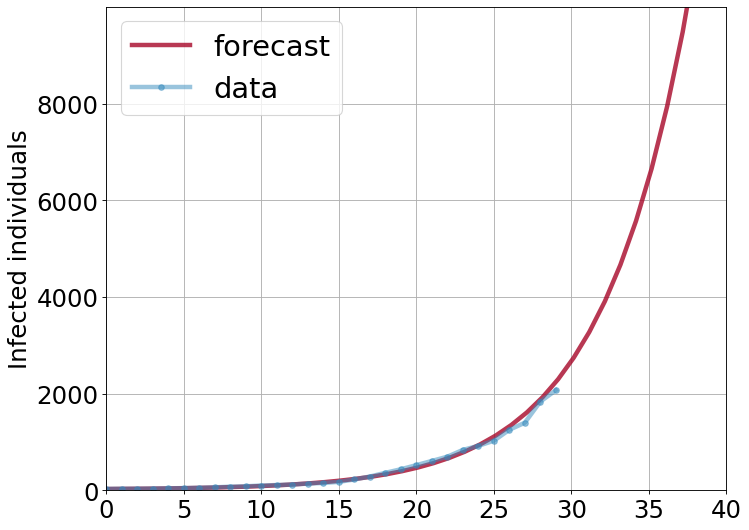

In [6]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
        
        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)


my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=4)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=5, label='data', alpha=0.5)

plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.xlim(0, 40); plt.ylim(0, 9999);

---

* Additional Visualizations, (as per the above steps these can also be added to AGOL.)

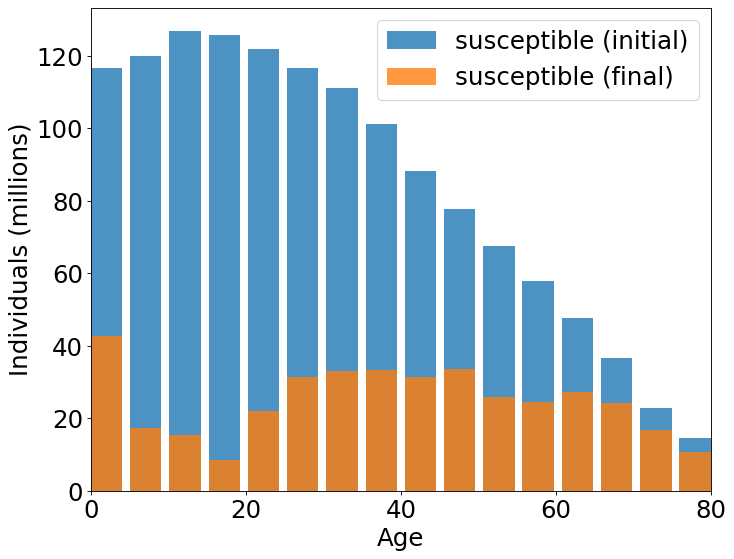

In [7]:

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.bar(np.arange(16),data['X'][0,0:M]*10**(-6),   label='susceptible (initial)', alpha=0.8)
plt.bar(np.arange(16),data['X'][-1,0:M]*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Individuals (millions)'); plt.xlabel('Age')
plt.legend(fontsize=22); plt.axis('tight')
plt.autoscale(enable=True, axis='x', tight=True)

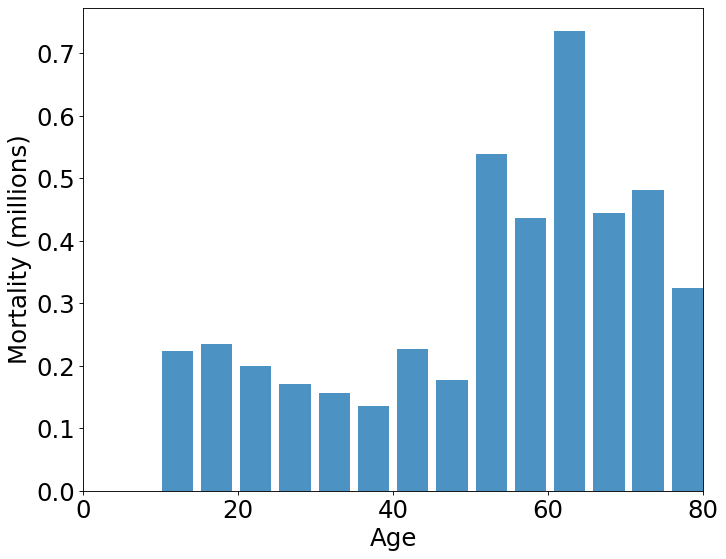

In [8]:
## Fatality Rate by AGE per 100 cases
MM = np.array((0,0,.2,.2,.2,.2,.2,.2,.4,.4,1.3,1.3,3.6,3.6,8,8))  


fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

m1 = .01*MM*(data['X'][0,0:M]-data['X'][-1,0:M])
plt.bar(np.arange(16),m1*10**(-6),   label='susceptible (final)', alpha=0.8)

plt.axis('tight'); plt.xticks(np.arange(-0.4, 16.45, 3.95), ('0', '20', '40', '60', '80'));
plt.xlim(-0.45, 15.45); plt.ylabel('Mortality (millions)'); plt.xlabel('Age')

plt.autoscale(enable=True, axis='x', tight=True)

---

---

---